
<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>



<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week06/01_Notebook_MNIST_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Clasificando digitos con Redes Neuronales 

Uno de los conjuntos de datos ampliamente utilizados para la clasificación de imágenes es el conjunto de datos MNIST (LeCun et al., 1998) de dígitos escritos a mano. En el momento de su lanzamiento en la década de 1990, planteó un desafío formidable para la mayoría de los algoritmos de aprendizaje automático, que constaba de 60.000 imágenes de  resolución28x28  de píxeles (más un conjunto de datos de prueba de 10,000 imágenes).

 Lograr una alta precisión en el reconocimiento de dígitos fue un componente clave en la automatización de la clasificación de cartas para el servicio postal de EEUU.

Durante más de una década, MNIST sirvió como punto de referencia para comparar algoritmos de aprendizaje automático.

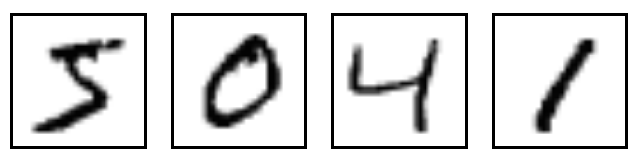


## Llamando las librerías

In [1]:
# install.packages("pacman") #run this line if you use Google Colab

In [14]:
require('pacman')
p_load("tidyverse","keras3","caret")

## Cargamos los datos

In [15]:
set.seed(10101)

mnist <- dataset_mnist()

### Muestra de entrenamiento

In [16]:
# X de entrenamiento
x_train <- mnist$train$x
dim(x_train)

[1] 60000    28    28

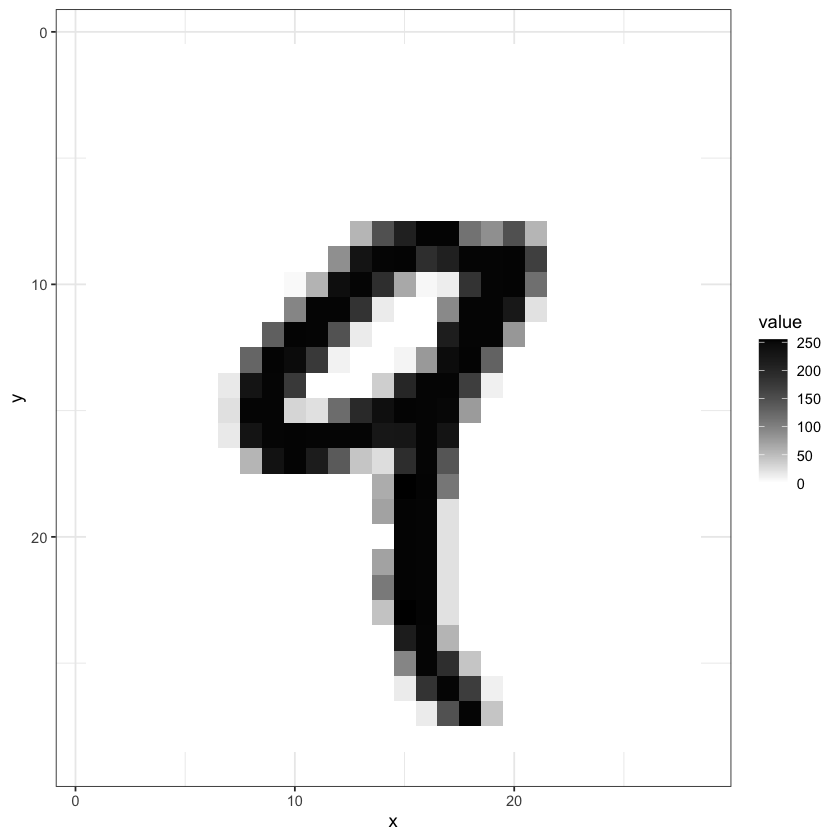

In [17]:
image_1 <- as.data.frame(x_train[5, , ]) 
colnames(image_1) <- seq_len(ncol(image_1))
image_1$y <- seq_len(nrow(image_1))
image_1 <- gather(image_1, "x", "value", -y)
image_1$x <- as.integer(image_1$x)

ggplot(image_1, aes(x = x, y = y, fill = value)) +
  geom_tile() +
  scale_fill_gradient(low = "white", high = "black", na.value = NA) +
  scale_y_reverse() +
  theme_bw()

In [18]:
# Variable dependiente -> target
y_train <- mnist$train$y
head(y_train)

[1] 5 0 4 1 9 2

### Muestra de Prueba

In [19]:
x_test <- mnist$test$x


In [20]:
y_test <- mnist$test$y

### Limpieza de los datos

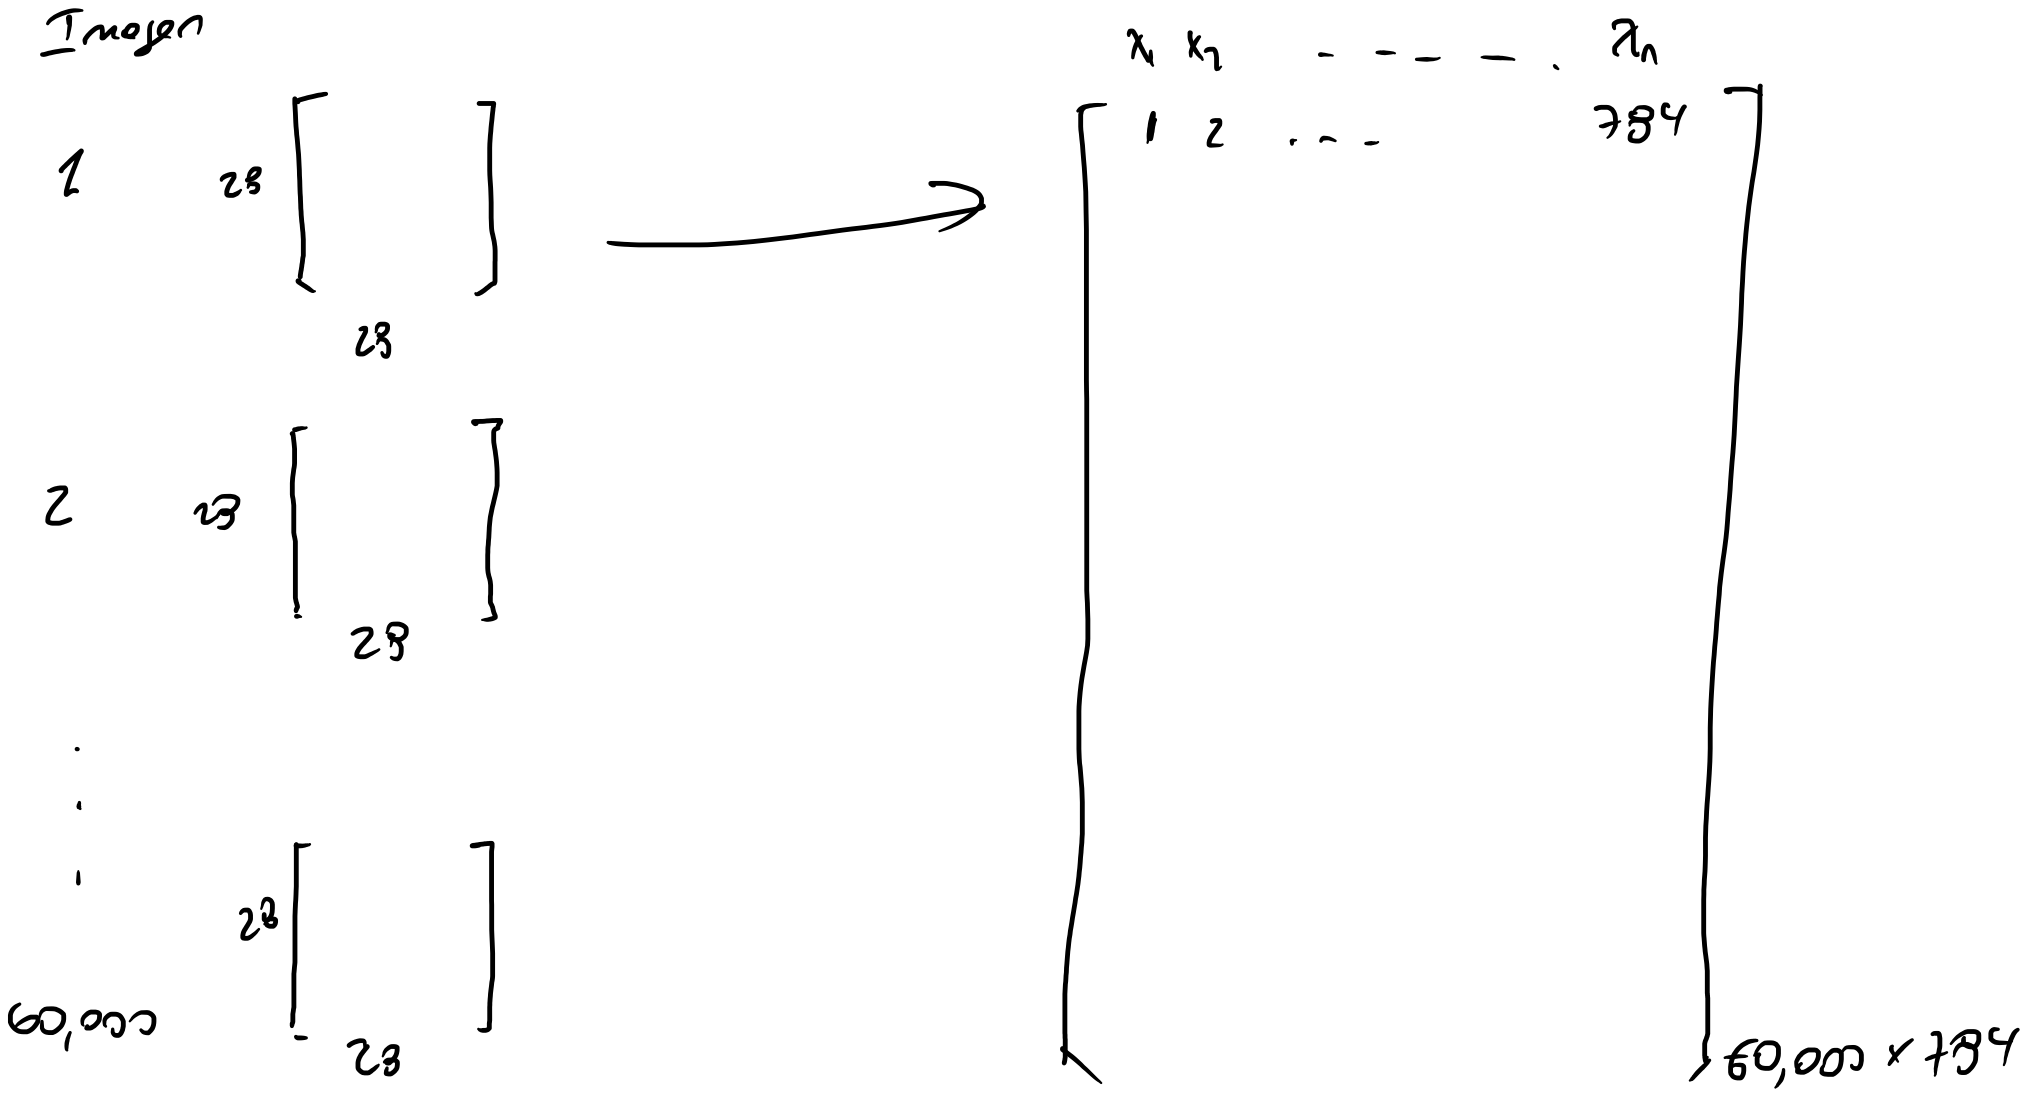

In [21]:
# reshape
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
dim(x_train)

[1] 60000   784

In [22]:
x_test <- array_reshape(x_test, c(nrow(x_test), 784))

In [23]:
# rescale pixeles entre 0 y 1
x_train <- x_train / 255
x_test <- x_test / 255

## Armando la primer red

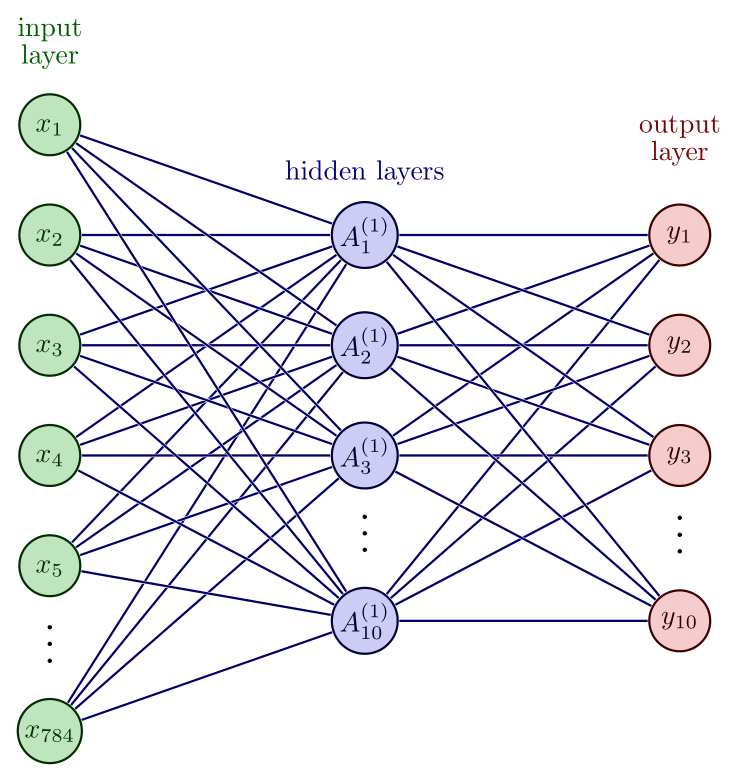

In [24]:
model <- keras_model_sequential(input_shape = c(784))
model %>% 
  layer_dense(units = 256, activation = 'relu') %>% 
  layer_dense(units = 10, activation = 'softmax')

### Dense

En una capa `layer_dense`, cada neurona está conectada a todas las neuronas de la capa anterior. Los `units`que se especifican en los parámetros, se refieren a la cantidad de neuronas que se deben incluir en una capa determinada de la red neuronal. Es decir, los units son el número de nodos de la capa. Por último, el parámetro `activation`  especifica la función de activación que se va a usar en esa capa de la red.



### Capa de salida: The softmax function

Multinomial logistic 

\begin{align}
 \Pr(Y_{i}=k)={\frac {e^{{\boldsymbol {\beta }}_{k}\cdot \mathbf {A} _{i}}}{\sum _{j=1}^{K}e^{{\boldsymbol {\beta }}_{j}\cdot \mathbf {A} _{i}}}}
\end{align}




In [ ]:
beta_A<-c(1.3,2.2,0.7,1.1,2.5,7.3,3.1,4.5,1.3,1.8)

pr<-exp(beta_A)/sum(exp(beta_A))

pr

#### Target como categóricos
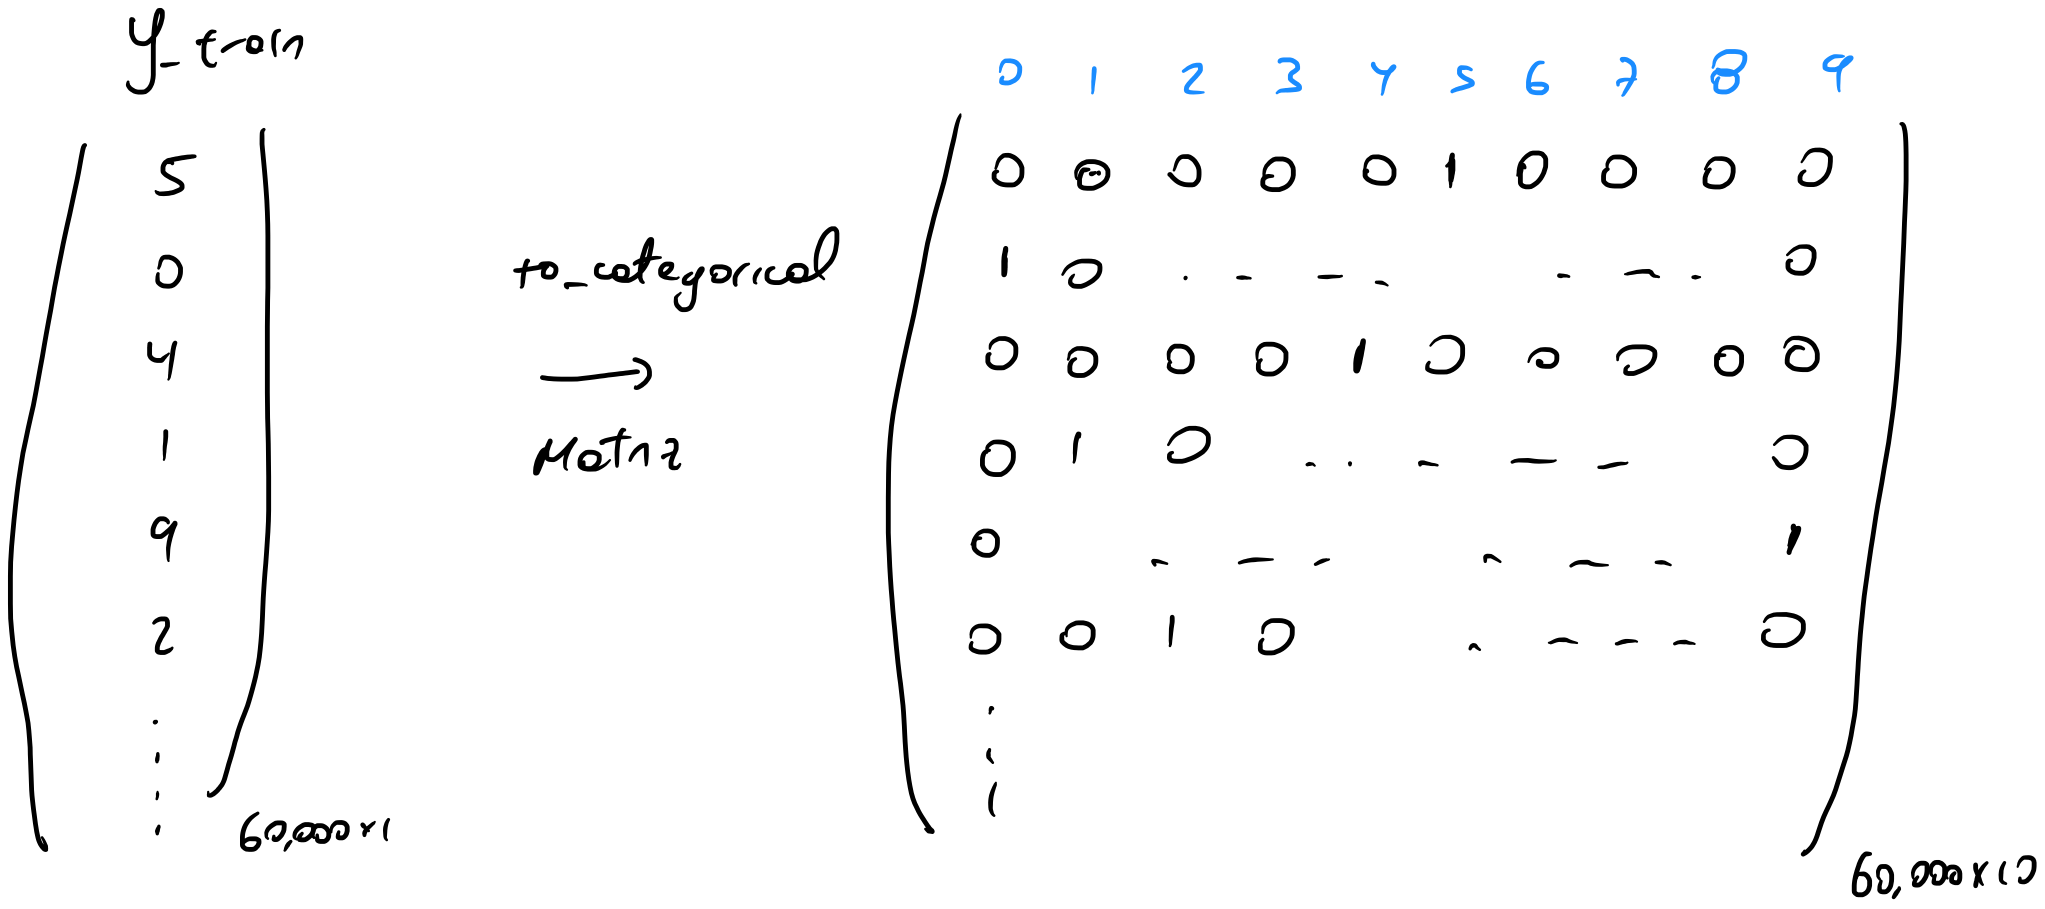

In [25]:
y_train <- to_categorical(y_train, 10)
y_test <- to_categorical(y_test, 10)
head(y_train)

0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1
0,0,1,0,0,0,0,0,0,0


## Modelo Final

In [26]:
summary(model)

Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                   │ (None, 256)              │       200,960 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_5 (Dense)                   │ (None, 10)               │         2,570 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 203,530 (795.04 KB)
 Trainable params: 203,530 (795.04 KB)
 Non-trainable params: 0 (0.00 B)


## Entrenando la primera red

In [27]:
model %>% compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

### Función de pérdida

Cross-entropy nos permite medir el error entre las probabilidades predichas y los verdaderos valores

$$
L(\theta) =\sum _{k=1}^{K} 1(Y=k)  \log_2 \left(\hat{Pr}(Y=k)\right) 
$$



In [28]:
L <- y_train[1,]*log2(0.91)

L

[1]  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 -0.1360615
 [7]  0.0000000  0.0000000  0.0000000  0.0000000

In [29]:
sum(L)

[1] -0.1360615

### Optimizador

 `Adam`  un algoritmo de optimización de gradiente descendiente estocástico popular utilizado en el aprendizaje automático y la optimización de redes neuronales. Para saber más de este pueden ir [acá](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

### Métrica 

Usamos `accuracy` como métrica de desempeño. 

$$
\text{accuracy} = \frac{\text{correct predictions}}{\text{total predictions}}
$$

Buscamos ver la proporción de dígitos clasificados correctamente

In [30]:
set.seed(101010)
history <- model %>% fit(
  x_train, y_train, 
  epochs = 30, 
  batch_size = 256,# 2^algún numero 
  validation_split = 0.2
)

In [ ]:
plot(history)

In [31]:
model %>% evaluate(x_test, y_test)

$accuracy
[1] 0.9713

$loss
[1] 0.09995403

In [32]:
y_hat <- model  %>% predict(x_test) %>% k_argmax() #categoría con probabilidad mas alta
y_hat

tf.Tensor([7 2 1 ... 4 5 6], shape=(10000), dtype=int64)

In [33]:
confusionMatrix(data = factor(as.numeric(y_hat), levels = 0:9), 
  reference = factor(mnist$test$y, levels = 0:9))

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4    5    6    7    8    9
         0  972    0    5    0    1    3    8    0    5    3
         1    0 1123    2    0    0    1    3   12    1    6
         2    1    3 1005    6    5    1    0   12    4    2
         3    0    0    3  982    0   12    1    5   11   10
         4    0    0    0    0  957    1    6    2    3   14
         5    2    1    0    5    0  856    6    1    4    2
         6    2    2    5    0    3   11  930    0    6    1
         7    1    0    5    7    2    0    0  990    4    6
         8    2    6    7    8    2    5    4    0  934    1
         9    0    0    0    2   12    2    0    6    2  964

Overall Statistics
                                          
               Accuracy : 0.9713          
                 95% CI : (0.9678, 0.9745)
    No Information Rate : 0.1135          
    P-Value [Acc > NIR] : < 2.2e-16       
                                         

## Arquitectura de redes y capas múltiples

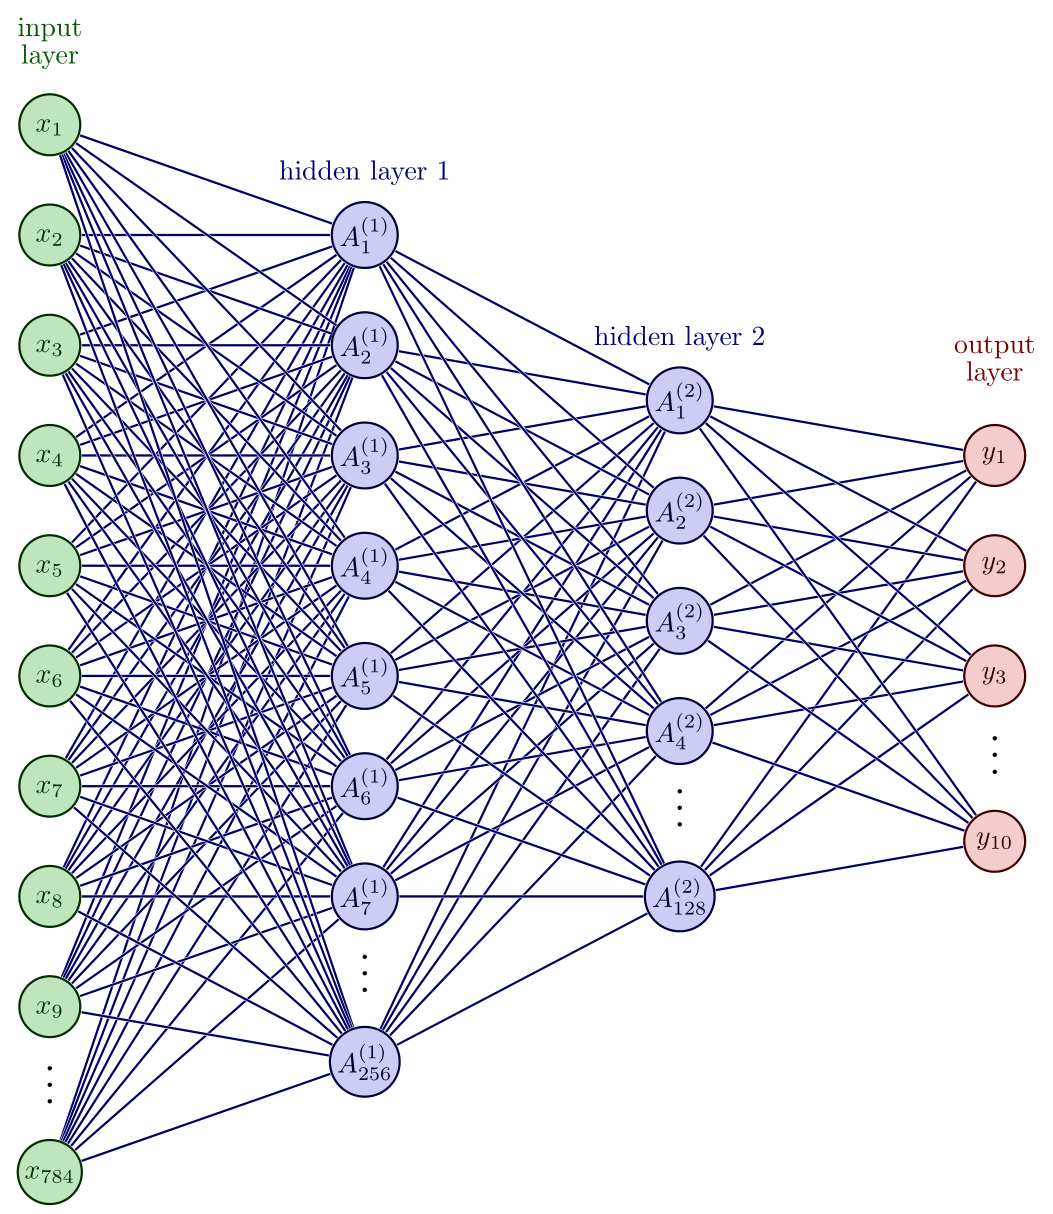

In [34]:
model2 <- keras_model_sequential(input_shape = c(784)) 

model2 %>%
layer_dense(units = 256, activation = 'relu') %>% 
layer_dense(units = 128, activation = 'relu') %>%
layer_dense(units = 10, activation = 'softmax')

In [35]:
summary(model2)

Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                   │ (None, 256)              │       200,960 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_7 (Dense)                   │ (None, 128)              │        32,896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_8 (Dense)                   │ (None, 10)               │         1,290 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘
 Total params: 235,146 (918.54 KB)
 Trainable params: 235,146 (918.54 KB)
 Non-trainable params: 0 (0.00 B)


In [36]:
model2 %>% compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

In [37]:
set.seed(101010)
history2 <- model2 %>% fit(
  x_train, y_train, 
  epochs = 8, 
  batch_size = 128,
  validation_split = 0.2
)

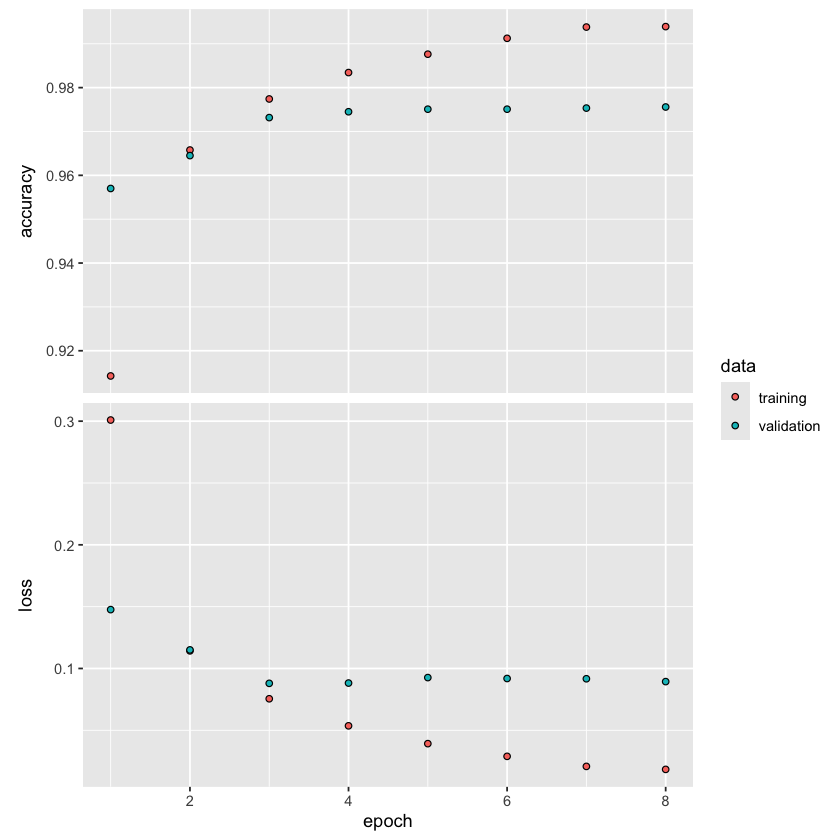

In [38]:
plot(history2)

In [39]:
model2 %>% evaluate(x_test, y_test)

$accuracy
[1] 0.978

$loss
[1] 0.07890831

## Dropout Learning

Esta es una forma de regularización relativamente nueva y eficiente. Inspirado en los random forest, la idea es eliminar aleatoriamente una fracción $\phi$ de las unidades en una capa al ajustar el modelo. 

Las unidades sobrevivientes sustituyen a las que faltan y sus pesos aumentan en un factor de 1/(1 − φ) para compensar. Esto evita que los nodos se especialicen demasiado, llevando a sobreajuste.

Puede ser visto como una forma de regularización. 

En la práctica, el "dropout" se logra configurando aleatoriamente los nodos  "abandonados" a cero, mientras se mantiene intacta la arquitectura.

In [40]:
model3 <- keras_model_sequential() 

model3 %>%
layer_dense(units = 256, activation = 'relu', input_shape = c(784)) %>% 
layer_dropout(rate = 0.4) %>%
layer_dense(units = 128, activation = 'relu') %>%
layer_dropout(rate = 0.3) %>%
layer_dense(units = 10, activation = 'softmax')

In [41]:
model3 %>% compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

In [42]:
set.seed(101010)
history3 <- model3 %>% fit(
  x_train, y_train, 
  epochs = 30, 
  batch_size = 128,
  validation_split = 0.2
)

In [43]:
model3 %>% evaluate(x_test, y_test)

$accuracy
[1] 0.9825

$loss
[1] 0.07279962

# Convolutional Neural Networks (LeNet)

En nuestro análisis inicial de datos de imágenes, aplicamos un modelo de red neuronal de múltiples capas (MLP). Para procesar estos datos, primero aplanamos cada imagen de una matriz de \(28 \times 28\) a un vector de longitud fija de 784 dimensiones, y luego los pasamos por capas completamente conectadas. 

Ahora que comprendemos cómo funcionan las capas convolucionales, podemos mantener la estructura espacial de las imágenes. Además, al reemplazar las capas completamente conectadas por capas convolucionales, logramos modelos más compactos que requieren muchos menos parámetros.

En esta sección, presentamos *LeNet* (1998), una de las primeras CNN que ganó gran reconocimiento por su desempeño en tareas de visión por computadora. Este modelo fue introducido (y nombrado) por Yann LeCun, entonces investigador en AT&T Bell Labs, con el propósito de reconocer dígitos escritos a mano en imágenes  

En su momento, LeNet logró resultados sobresalientes. Con el tiempo, LeNet se adaptó para reconocer dígitos en el procesamiento de depósitos en cajeros automáticos. ¡A día de hoy, algunos cajeros automáticos aún ejecutan el código que Yann LeCun y su colega Leon Bottou desarrollaron en los años 90!

In [44]:
# Input image dimensions
img_rows <- 28
img_cols <- 28

x_train <- array_reshape(x_train, c(nrow(x_train), img_rows, img_cols, 1))
x_test <- array_reshape(x_test, c(nrow(x_test), img_rows, img_cols, 1))
input_shape <- c(img_rows, img_cols, 1)
input_shape

[1] 28 28  1

<div >
<img src = "figs/lenet-vert.svg" />
</div>

In [45]:
lenet <- keras_model_sequential() 

lenet %>%
    layer_conv_2d(filters = 6, kernel_size = c(5, 5), 
                  activation = 'sigmoid', padding = 'same', 
                  input_shape = input_shape) %>%
    layer_average_pooling_2d(pool_size = c(2, 2), strides = c(2, 2)) %>%
    layer_conv_2d(filters = 16, kernel_size = c(5, 5), activation = 'sigmoid') %>%
    layer_average_pooling_2d(pool_size = c(2, 2), strides = c(2, 2)) %>%
    layer_flatten() %>%
    layer_dense(units = 120, activation = 'sigmoid') %>%
    layer_dense(units = 84, activation = 'sigmoid') %>%
     layer_dense(units = 10, activation = 'softmax')

In [46]:
lenet %>% compile(
   optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

In [47]:
set.seed(101010)
lenet_history <- lenet %>% fit(
  x_train, y_train, 
  epochs = 10, 
  batch_size = 128,
  validation_split = 0.2
)

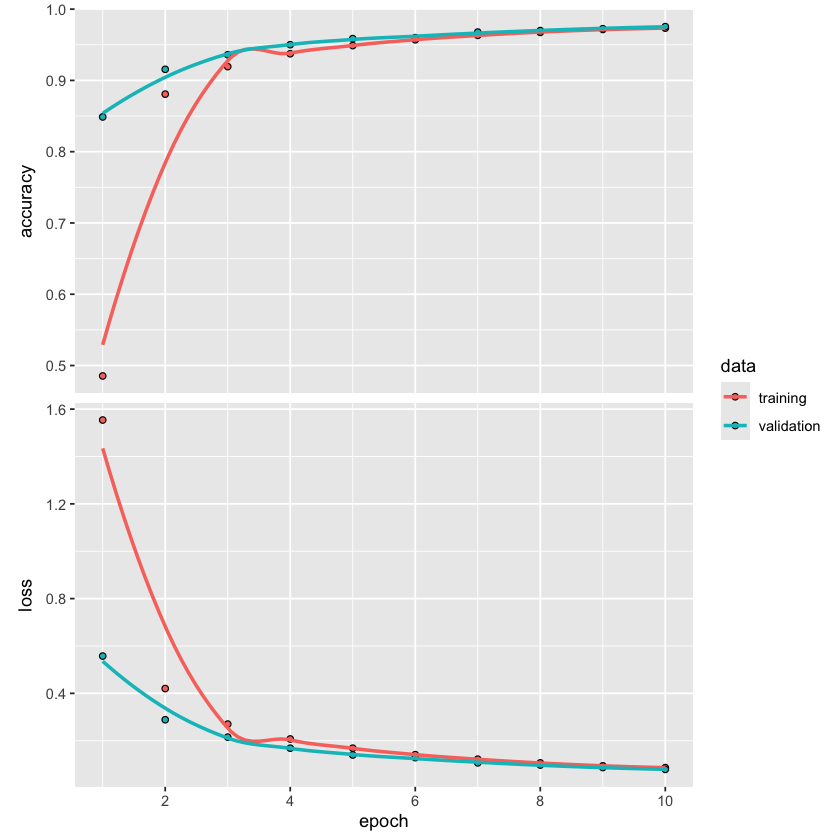

In [48]:
plot(lenet_history)

In [49]:
lenet  %>% evaluate(x_test, y_test)

$accuracy
[1] 0.9769

$loss
[1] 0.07539285

## Otra arquitectura

Probemos otra arquitectura un poco mas compleja.

In [50]:
cnn_model <- keras_model_sequential() 

cnn_model %>%
  layer_conv_2d(filters = 32, kernel_size = c(3,3), activation = 'relu', input_shape =input_shape) %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3,3), activation = 'relu') %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_dropout(rate = 0.25) %>% 
  layer_flatten() %>% 
  layer_dense(units = 128, activation = 'relu') %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 10, activation = 'softmax')

In [51]:
cnn_model %>% compile(
   optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = c('accuracy')
)

In [52]:
set.seed(101010)
cnn_history <- cnn_model %>% fit(
  x_train, y_train, 
  epochs = 10, 
  batch_size = 128,
  validation_split = 0.2
)

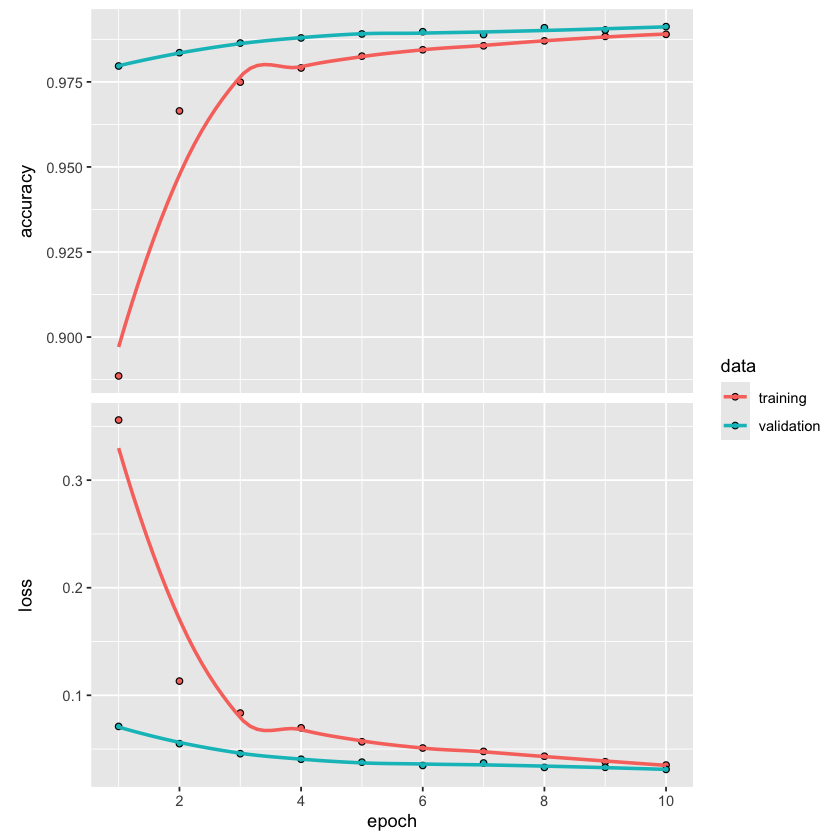

In [53]:
plot(cnn_history)

In [54]:
cnn_model %>% evaluate(x_test, y_test)

$accuracy
[1] 0.9919

$loss
[1] 0.02367289